CIFAR-100
=====

CIFAR-100 데이터를 이용한 Image classification 연습
---------------------------------------------

<center>
<h2>[Spatially-sparse convolutional neural networks](https://arxiv.org/abs/1409.6070)</h2>   
Benjamin Graham      
Dept of Statistics, University of Warwick, CV4 7AL, UK   
b.graham@warwick.ac.uk   
September 23, 2014   

arXiv:1409.6070v1 [cs.CV] 22 Sep 2014
</center>

---

위 논문은 DeepCNet을 소개한다.   
아래 알고리즘은 논문에서 CIFAR 100 - Accuracy : 75.7% 를 달성한 DeepCNiN 구조이다.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import prettytensor as pt
from sklearn.metrics import confusion_matrix
import numpy as np
import time
from datetime import datetime
from datetime import timedelta
import math
import os
import cifar100

In [2]:
tf.__version__

'1.2.0'

In [3]:
pt.__version__

'0.7.4'

## 데이터 불러오기

In [4]:
cifar100.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


cifar100 데이터는 32X32 크기의 사진 6만장이 들어있다.  
그 중 5만장은 Test set, 1만장은 Test set 으로 구성되어 있다.  
이미지의 class 는 100개이고 각 class 마다 균등하게 배분되어 있다.

사실 CIFAR100은 상위 클레스가 존재하는 데 20개로 구성되어 있고, 하위로 각 5개씩 존재해서 100개인 것이다.  
상위 클레스로 20개만 사용하고 싶으면 cifa100.py에  다음과 같이 대체하자. 
* label에 "coarse_labels"
* meta에 "coarse_label_names"

In [5]:
class_names = cifar100.load_class_names()
class_names[:10]

Loading data: data/CIFAR-100/cifar-100-python/meta


['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle']

각 data set을 로드한다. Training set은 용량 문제로 5개의 배치파일로 분리되어 있다.

In [6]:
images_train, cls_train, labels_train = cifar100.load_training_data()

Loading data: data/CIFAR-100/cifar-100-python/train


Load the test-set.

In [7]:
images_test, cls_test, labels_test = cifar100.load_test_data()

Loading data: data/CIFAR-100/cifar-100-python/test


In [8]:
print("Size of:")
print("- Training-set:\t{}".format(len(images_train)))
print("- Test-set:\t{}".format(len(images_test)))

Size of:
- Training-set:	50000
- Test-set:	10000


### Data Dimensions

In [9]:
from cifar100 import img_size, num_channels, num_classes

DeepCNet(L, K) 라는 표현법이 있다.   예를들어 DeepCNet(4, 100) 는  
* Input size = (3 x 2^4) = 48

그리고 Model architecture 는  
* Input - 100C3 - MP2 - 200C2 - MP2 - 300C2 - MP2 - 400C2 - MP2 - 500C2 - Output 

DeepCNiN(4, 100) 은 다음과 같은 구조를 갖는다.  
```
input−100C3 − MP2 − 100C1 − . . .
· · · −200C2 − MP2 − 200C1 − . . .
· · · −300C2 − MP2 − 300C1 − . . .
· · · −400C2 − MP2 − 400C1 − . . .
· · · −500C2 − 500C1 − output
```

CIFAR 100 데이터는 32x32 크기의 이미지이므로 주변에 zero padding 을 하여 48크기로 만즐어 주는 작업이 필요하다.

In [10]:
img_size_padding = 54
img_size_cropped = 48

### 데이터가 올바른지 확인하기 위해 몇가지 이미지를 확인한다.

3x3 그리드에 9개의 이미지를 그리는 데 사용되는 함수이며, 각 이미지 아래의 실제 및 예상 class를 보여준다.

In [11]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    fig, axes = plt.subplots(3, 3)

    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
        
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):

        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        ax.imshow(images[i, :, :, :], interpolation=interpolation)
            
        cls_true_name = class_names[cls_true[i]]

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig = plt.gcf()
    fig.set_size_inches(8, 8, forward=True)    
    plt.show()

다음 사진은 test set의 처음 9개의 사진이다.

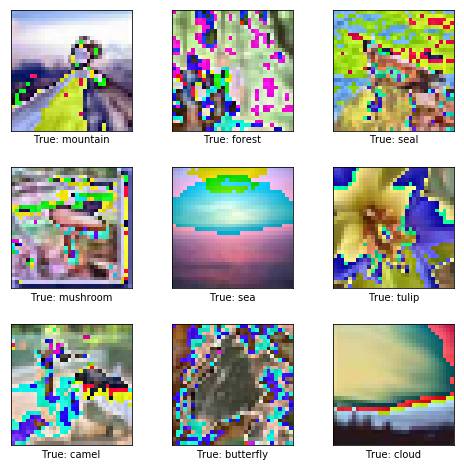

In [12]:
images = images_test[0:9]
cls_true = cls_test[0:9]

plot_images(images=images, cls_true=cls_true, smooth=False)

plt 패키지의 spline16를 이용해서 사진을 부드럽게 만들 수 있다.

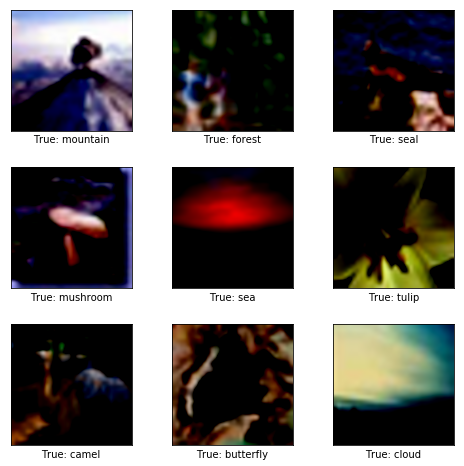

In [13]:
plot_images(images=images, cls_true=cls_true, smooth=True)

## TensorFlow Graph

### Placeholder variables

In [14]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

y_true_cls = tf.argmax(y_true, 1)

### 이미지 전처리 작업

In [15]:
def pre_process_image(image, training):
    
    if training:
                
        # DeepNiN
        image = tf.image.resize_image_with_crop_or_pad(
            image, target_height=img_size_padding, target_width=img_size_padding)
        
        # 랜덤하게 부분적으로 잘라낸다.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
        
        # 랜덤하게 좌우 반전 한다.
        image = tf.image.random_flip_left_right(image)
        
        # 랜덤하게 색상, 대비, 밝기, 채도를 조정한다.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # 너무 심하게 바뀐 경우를 대비해 1과 0 사이값으로 맞춘다.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, -1.0)

    else:
        # 테스트시 중앙을 기준으로 이미지를 23x23으로 자른다.
        image = tf.image.resize_image_with_crop_or_pad(
            image, target_height=img_size_cropped, target_width=img_size_cropped)

    return image

In [16]:
def pre_process(images, training):
    
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)
    
    return images

In [17]:
distorted_images = pre_process(images=x, training=True)

In [18]:
distorted_images

<tf.Tensor 'map/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, 48, 48, 3) dtype=float32>

In [19]:
# @pt.Register
def lrelu(x, alpha=1/3, name="lrelu"):
    with tf.variable_scope(name):
#         f1 = 0.5 * (1 + leak)
#         f2 = 0.5 * (1 - leak)
#         x = f1 * x + f2 * abs(x)
        x = tf.maximum(x, alpha * x)
        return x

In [20]:
def main_network(images, training):
    x_pretty = pt.wrap(images)

    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    with pt.defaults_scope(activation_fn=lrelu, phase=phase):
        y_pred, loss = (x_pretty
                        
                        .conv2d(kernel=3, depth=100, name='layer_conv1_1').dropout(1.0)
                        .max_pool(kernel=2, stride=2)
                        .conv2d(kernel=1, depth=100, name='layer_conv1_2')
                        
                        .conv2d(kernel=2, depth=200, name='layer_conv2_1').dropout(0.9)
                        .max_pool(kernel=2, stride=2)
                        .conv2d(kernel=1, depth=200, name='layer_conv2_2')
                        
                        .conv2d(kernel=2, depth=300, name='layer_conv3_1').dropout(0.8)
                        .max_pool(kernel=2, stride=2)
                        .conv2d(kernel=1, depth=300, name='layer_conv3_2')
                        
                        .conv2d(kernel=2, depth=400, name='layer_conv4_1').dropout(0.7)
                        .max_pool(kernel=2, stride=2)
                        .conv2d(kernel=1, depth=400, name='layer_conv4_2')
                        
                        .conv2d(kernel=2, depth=500, name='layer_conv5_1').dropout(0.6)
                        .conv2d(kernel=1, depth=500, name='layer_conv5_2')
                        
                        .flatten()
                        
                        .softmax_classifier(num_classes=num_classes, labels=y_true))

    return y_pred, loss

In [21]:
def create_network(training):
    with tf.variable_scope('network', reuse=not training):
        
        images = pre_process(images=x, training=training)
        
        y_pred, loss = main_network(images=images, training=training)
        
    return y_pred, loss

### Training

만약 saver load가 있다면, 이전 step에 더해서 진행된다.

In [22]:
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)

In [23]:
_, loss = create_network(training=True)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss, global_step=global_step)

### Test / Pred

In [24]:
y_pred, _ = create_network(training=False)

y_pred_cls = tf.argmax(y_pred, dimension=1)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

In [25]:
saver = tf.train.Saver()

### Weights

In [26]:
def get_weights_variable(layer_name):
    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

나중에 weights 그림을 그리기 위함

In [27]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1_1')
weights_conv2 = get_weights_variable(layer_name='layer_conv1_2')

### Layer Outputs

In [28]:
def get_layer_output(layer_name):
    tensor_name = "network/" + layer_name + "/lrelu/Maximum:0"

    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

In [29]:
output_conv1 = get_layer_output(layer_name='layer_conv1_1')
output_conv2 = get_layer_output(layer_name='layer_conv1_2')

Tensor name 을 잘 모르겠다면, `[tensor.name for tensor in tf.get_default_graph().as_graph_def().node]` 으로 검색해보자.

## TensorFlow Run

메모리를 한번에 안잡기 위해서 `growth=True` 를 설정

In [30]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.Session(config=config)

In [31]:
save_dir = 'cifar100-checkpoints/'

In [32]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [33]:
save_path = os.path.join(save_dir, 'DeepCNIN4100')

In [34]:
try:
    print("Trying to restore last checkpoint ...")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    saver.restore(session, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
    
except:
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from cifar100-checkpoints/DeepCNIN4100-1000000
Restored checkpoint from: cifar100-checkpoints/DeepCNIN4100-1000000


### random training-batch

In [35]:
batch_size = 100

In [36]:
def random_batch():
    num_images = len(images_train)

    idx = np.random.choice(num_images, size=batch_size, replace=False)

    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

### optimization

In [37]:
def optimize(num_iterations):
    start_time = time.time()
    
    time_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("Learning start!. [{}]".format(time_now))
    
    for i in range(num_iterations):
        x_batch, y_true_batch = random_batch()

        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        i_global, _ = session.run([global_step, optimizer], feed_dict=feed_dict_train)

        if (i_global % 10000 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            msg = "Global Step: {0:>4}k, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(int(i_global/1000), batch_acc))

        if (i_global % 100000 == 0) or (i == num_iterations - 1):
            
            correct, cls_pred = predict_cls_test()
            acc, num_correct = classification_accuracy(correct)
            num_images = len(correct)
            # Print the accuracy.
            msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
            print(msg.format(acc, num_correct, num_images))

            saver.save(session, save_path=save_path, global_step=global_step) # 5만번 마다 save

            time_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print("Saved checkpoint. [{}]".format(time_now))

    end_time = time.time()
    time_dif = end_time - start_time

    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### plot example errors

Predict 시 못맞춘 것을 가지고와 보여준다.

In [38]:
def plot_example_errors(cls_pred, correct):

    incorrect = (correct == False)
    
    images = images_test[incorrect]
    
    cls_pred = cls_pred[incorrect]

    cls_true = cls_test[incorrect]
    
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### plot confusion matrix

In [39]:
def plot_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=cls_test, y_pred=cls_pred)
    
    for i in range(num_classes):
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### calculating classifications

In [40]:
batch_size_test = 100

In [41]:
def predict_cls(images, labels, cls_true):
    num_images = len(images)

    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    i = 0

    while i < num_images:
        j = min(i + batch_size_test, num_images)

        feed_dict = {x: images[i:j, :], y_true: labels[i:j, :]}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j

    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [42]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

### classification accuracy

In [43]:
def classification_accuracy(correct):

    return correct.mean(), correct.sum()

### Test accuracy

In [44]:
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):

    correct, cls_pred = predict_cls_test()
    
    acc, num_correct = classification_accuracy(correct)
    
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### plotting convolutional weights

In [45]:
def plot_conv_weights(weights, input_channel=0):
    
    w = session.run(weights)

    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    num_filters = w.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w[:, :, input_channel, i]
            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max, interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig = plt.gcf()
    fig.set_size_inches(8, 8, forward=True)    
    plt.show()

### plotting the output of convolutional layers

In [46]:
def plot_layer_output(layer_output, image):
    
    feed_dict = {x: [image]}
    
    # Retrieve the output of the layer after inputting this image.
    values = session.run(layer_output, feed_dict=feed_dict)

    values_min = np.min(values)
    values_max = np.max(values)

    # Number of image channels output by the conv. layer.
    num_images = values.shape[3]

    # Number of grid-cells to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_images))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i<num_images:
            # Get the images for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, vmin=values_min, vmax=values_max, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig = plt.gcf()
    fig.set_size_inches(8, 8, forward=True)    
    plt.show()

## Examples of distorted input images

In [47]:
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    feed_dict = {x: image_duplicates}

    result = session.run(distorted_images, feed_dict=feed_dict)

    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

In [48]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

In [49]:
img, cls = get_test_image(5)

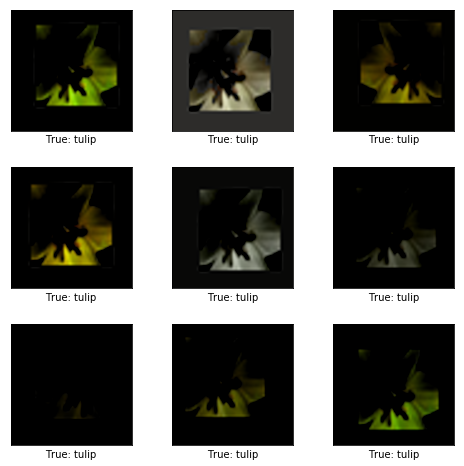

In [50]:
plot_distorted_image(img, cls)

## Perform optimization

* Batch size = 100
* num_images = 50,000
* 500 iterations == 1 Epoch

In [51]:
# if True:
if False:
    optimize(num_iterations=1000000)

## Results

Accuracy on Test-Set: 54.6% (5462 / 10000)
Example errors:


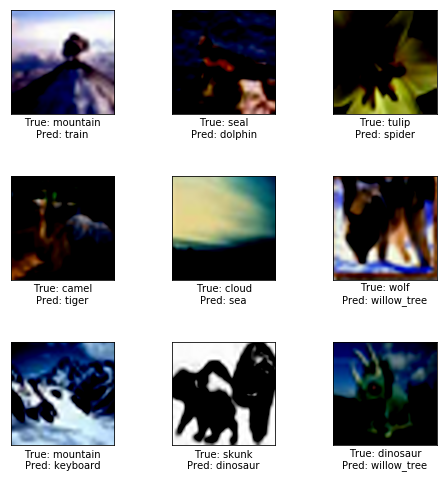

In [52]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=False)

### Convolutional Weights

Min:  -0.92115, Max:   1.01229
Mean: -0.00020, Stdev: 0.13115


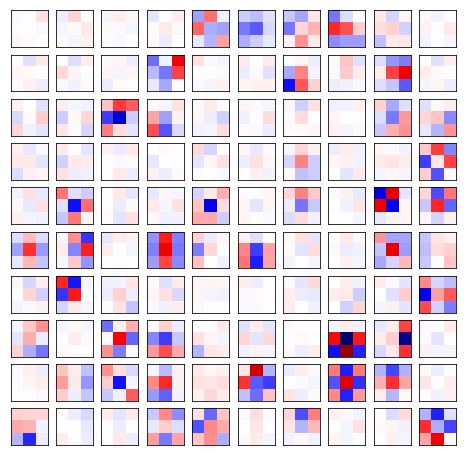

In [53]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

Min:  -0.52809, Max:   0.33274
Mean: -0.00453, Stdev: 0.04259


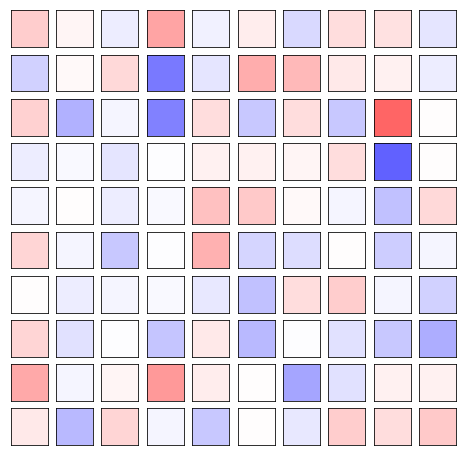

In [54]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

### Output of convolutional layers

In [55]:
def plot_image(image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 2)

    # References to the sub-plots.
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    # Show raw and smoothened images in sub-plots.
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    # Set labels.
    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    
    
    fig = plt.gcf()
    fig.set_size_inches(8, 8, forward=True)
    plt.show()

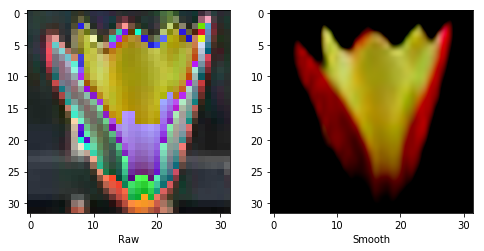

In [56]:
img, cls = get_test_image(16)
plot_image(img)

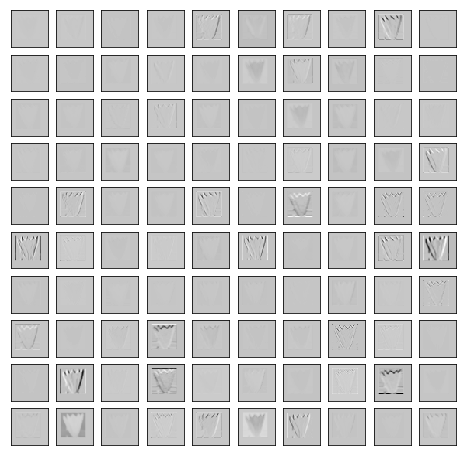

In [57]:
plot_layer_output(output_conv1, image=img)

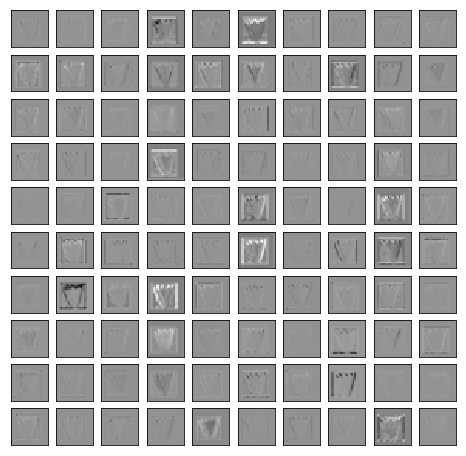

In [58]:
plot_layer_output(output_conv2, image=img)

### Predicted class-labels

In [59]:
label_pred, cls_pred = session.run([y_pred, y_pred_cls], feed_dict={x: [img]})

In [60]:
np.set_printoptions(precision=3, suppress=True)

print(label_pred[0])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


In [61]:
class_names[92]

'tulip'

In [62]:
class_names[16]

'can'

## Close TensorFlow Session

In [63]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## Conclusion

This tutorial showed how to make a Convolutional Neural Network for classifying images in the CIFAR-10 data-set. The classification accuracy was about 79-80% on the test-set.

The output of the convolutional layers was also plotted, but it was difficult to see how the neural network recognizes and classifies the input images. Better visualization techniques are needed.